In [2]:
import os
import shutil
import glob
import gzip
import sys

import numpy as np
import netCDF4 as nc4
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import cmocean

import cftime

import pyart

from datetime import date

from ipyfilechooser import FileChooser

today = date.today()
datestr = today.strftime("%Y%m%d")
# Uncomment the following line if you want to set the date manually
datestr = '20220907';

    

# Set scales on plots
dcscale  = [0   , 200];
hscale   = [0   , 12];
Zscale   = [-10 , 50];
ZDRscale = [-1  , 3];
Lscale   = [1   , 2.5];
PDPscale = [0   , 20];
Vscale   = [-15 , 15];
SPWscale = [0   , 2.5];
LDRscale = [-35 , -15];

print(dcscale,hscale);


camra_raw_path = '/focus/radar-camra/raw/{}'.format(datestr);

figpath = '/home/cw66/public_html/wescon'
figpath = os.path.join(figpath,datestr);
# Check whether the specified path exists or not
isExist = os.path.exists(figpath);

if not isExist:
  os.makedirs(figpath)

# Create and display a FileChooser widget
fc = FileChooser(title="Select radar file",path=camra_raw_path)

fc.filter_pattern = '*.nc'

ncfile = fc.selected_filename;

display(fc)

os.chdir(camra_raw_path);
ppis = [os.path.join(camra_raw_path,f) for f in glob.glob('*{}*ppi-raw.nc'.format(datestr))];
ppis.sort();
rhis = [os.path.join(camra_raw_path,f) for f in glob.glob('*{}*rhi-raw.nc'.format(datestr))];
rhis.sort();
mans = [os.path.join(camra_raw_path,f) for f in glob.glob('*{}*man-raw.nc'.format(datestr))];
mans.sort();





## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

[0, 200] [0, 12]


FileChooser(path='/focus/radar-camra/raw/20220907', filename='', title='HTML(value='Select radar file')', show…

In [33]:
savedSet=set()

In [50]:
nameSet=set()
for file in os.listdir(camra_raw_path):
    fullpath=os.path.join(camra_raw_path, file)
    if os.path.isfile(fullpath):
        nameSet.add(file)
        
retrievedSet=set()
for name in nameSet:
    stat=os.stat(os.path.join(camra_raw_path, name))
    #time=ST_CTIME
    #size=stat.ST_SIZE If you add this, you will be able to detect file size changes as well.
    #Also consider using ST_MTIME to detect last time modified
    retrievedSet.add(name)
    
newSet=retrievedSet-savedSet

deletedSet=savedSet-retrievedSet

savedSet=newSet

newlist = list(newSet);

newlist.sort()

#print(newlist);

#rawplot(newlist[-1])
#for file in newSet:
#    print(file);
#    rawplot(file);


import time

seconds_ago = 60*60*8+120;

files = (fle for rt, _, f in os.walk(camra_raw_path) for fle in f if time.time() - os.stat(
    os.path.join(rt, fle)).st_mtime < seconds_ago)

print(list(files))


['radar-camra_20220907115554_rhi-raw.nc', 'radar-camra_20220907115626_rhi-raw.nc', 'radar-camra_20220907115656_rhi-raw.nc', 'radar-camra_20220907115726_rhi-raw.nc', 'radar-camra_20220907115757_rhi-raw.nc']


In [23]:
#ncfile = os.path.join(camra_raw_path,fc.selected);


print(ncfile)

def scanco(DS):
    
    rangekm = DS['range'][:]/1000.0;
    elev = DS['elevation'][:];
    azim = DS['azimuth'][:];

    direction = np.sign(np.sin(np.mean(azim[:])*np.pi/180));
    
    r_earth = 6371;
    r_earth = r_earth*4/3;

    r = np.cos(elev[:,None]*np.pi/180) * rangekm[None,:];

    z = np.sin(elev[:,None]*np.pi/180) * rangekm[None,:] + np.sqrt(r**2 + r_earth**2) - r_earth;
    x = np.sin(azim[:,None]*np.pi/180) * np.cos(elev[:,None]*np.pi/180) * rangekm[None,:];
    y = np.cos(azim[:,None]*np.pi/180) * np.cos(elev[:,None]*np.pi/180) * rangekm[None,:];

    return direction,r,x,y,z

def rawplot(ncfile):
    
    DS = nc4.Dataset(ncfile);

    dtime0 = cftime.num2pydate(DS['time'][:],DS['time'].units)

    title_date = dtime0[0].strftime("%Y%m%d %H:%M UTC");
    figdate = dtime0[0].strftime("%Y%m%d%H%M%S")

    direction,r,x,y,z = scanco(DS);
    
    fig, ax = plt.subplots(2,1,figsize=(12,4*2),constrained_layout=True)
    fig.set_constrained_layout_pads(w_pad=2 / 72, h_pad=2 / 72, hspace=0.2,wspace=0.2)

    h0=ax[0].pcolor(r,z,DS['ZED_H'][:-1,:-1],cmap='pyart_HomeyerRainbow',vmin=Zscale[0],vmax=Zscale[1])
    ax[0].set_ylim(hscale[0],hscale[1]);
    ax[0].set_xlim(dcscale[0],dcscale[1])
    cb0 = plt.colorbar(h0,ax=ax[0],orientation='horizontal',shrink=0.8);
    cb0.ax.set_xlabel("Reflectivity Factor (dBZ)");
    if direction<0:
        ax[0].invert_xaxis();

    h1=ax[1].pcolor(r,z,DS['VEL_HV'][:-1,:-1],cmap=cmocean.cm.balance,vmin=Vscale[0],vmax=Vscale[1])
    ax[1].set_ylim(hscale[0],hscale[1]);
    ax[1].set_xlim(dcscale[0],dcscale[1]);
    if direction<0:
        ax[1].invert_xaxis();

    cb1 = plt.colorbar(h1,ax=ax[1],orientation='horizontal',shrink=0.8);
    cb1.ax.set_xlabel("Doppler velocity (m/s)");
    


None


In [38]:
# OFFSETS/CALIBRATIONS:

import numpy.ma as ma

rangeOFFSET=0 #-840 %m
ZhOFFSET=0 #+7 %dB
ZDROFFSET=0 #+0.6 %+0.6 %dB 

SNR_threshold_HH=3.5;  	# for copolar H - default
SNR_threshold_VV=3.5; 	# for copolar V - default

SNR_threshold_HH=5;  	# for copolar H
SNR_threshold_VV=5; 	# for copolar V
SNR_threshold_X=3.5; 	# cross polar SNR threshold
SNR_threshold_CXC=100; 	# rho_hv and L : 200 corresponds to bias of 0.995
SNR_threshold_SPW=6; 	# spectral width thresholding
 
oldrange = DS['range'][:];
newrange = oldrange+rangeOFFSET;

#newrange(range<0) = nan;


Zh = DS['ZED_H'][:,:];    # Horizontal polarised reflectivity [dBZ] (copolar)
Zv = Zh - DS['ZDR'][:,:]; # Vertically polarised reflectivity [dBZ] (copolar)
Zx = Zh + DS['LDR'][:,:]; # cross polar V [dBZ]

PDP    = DS['PDP'][:,:] + 0; #-5.8; % Differential Phase Shift (deg)

SPW_HV = DS['SPW_HV'][:,:]; # spectral width using H & V pulses
V      = DS['VEL_HV'][:,:]; # Velocity from both H&V pulses (max range +/- 14.86m/s)
CXC    = DS['CXC'][:,:];    # copolar cross correlation rho_hv^2

linZ  = 10.0**(Zh/10.); signalpower=linZ*0; # linZ = reflectivities in linear units [mm^6/m^3]
linZv = 10.0**(Zv/10.); signalpowerv=linZv*0; 
linZx = 10.0**(Zx/10.); 

signalpowerx = linZx*0; 
signalpower  = Zh; 
signalpowerv=signalpower; 
signalpowerx=signalpower; # Just to get right array dimensions

signalpower  = linZ/oldrange[None,:]**2;
signalpowerv = linZv/oldrange[None,:]**2;
signalpowerx = linZx/oldrange[None,:]**2;

direction,r,x,y,z = scanco(DS)

#noise=5.347e-5; % estimated for 20110318
#noisev=5.216e-5;
#noisex=8.17e-5;
#sdnoise=2.5423e-06; % estimate 7 june 2016
#sdnoisex=3.4e-06; % --- %

print(z.shape)
emptygates=np.where(z>12); # & isnan(signalpower)==0  & isnan(signalpowerv)==0  & isnan(signalpowerx)==0
print(emptygates);

print(np.shape(emptygates));

#if length(emptygates)>50
noise=np.mean(signalpower[emptygates]); noisev=np.mean(signalpowerv[emptygates]); noisex=np.mean(signalpowerx[emptygates]);
sdnoise=np.std(signalpower[emptygates]); sdnoisev=np.std(signalpowerv[emptygates]); sdnoisex=np.std(signalpowerx[emptygates]);
#else % otherwise have to guess, based on previous data - this is most likely for PPIs
#noise=2.5971e-10; noisev=2.5280e-10; noisex=3.3132e-11;
#sdnoise=1.7784e-11; sdnoisev=1.7064e-11; sdnoisex=1.347e-12;
#end

#noise = 2.6e-10;


print(noise)

signalpower=signalpower-noise;	# subtract noise from signal
signalpowerv=signalpowerv-noisev;
signalpowerx=signalpowerx-noisex;

SNRperpulseH=signalpower/noise; SNRperpulseV=signalpowerv/noisev; iii=np.where(SNRperpulseH<0); SNRperpulseH[iii]=0; iii=np.where(SNRperpulseV<0); SNRperpulseV[iii]=0;
bringi_factor=np.sqrt((1+1./SNRperpulseH)*(1+1./SNRperpulseV));

signalpower = ma.masked_where(signalpower<SNR_threshold_HH*sdnoise, signalpower); 
signapowerv = ma.masked_where(signalpowerv<SNR_threshold_VV*sdnoise, signalpowerv); 
signalpowerx = ma.masked_where(signalpowerx<SNR_threshold_X*sdnoisex, signalpowerx);

linZ  = signalpower*newrange[None,:]**2;	# calculate linear Z from signal power using CORRECTED range
linZv = signalpowerv*newrange[None,:]**2;
linZx = signalpowerx*newrange[None,:]**2;

Zh=10*ma.log10(linZ)+ZhOFFSET;			#	 ADD ON CALIBRATION FACTORS
Zv=10*ma.log10(linZv)+ZhOFFSET-ZDROFFSET;
ZDR=Zh-Zv;  # CALCULATE ZDR [dB]
Zx=10*ma.log10(linZx)+ZhOFFSET-ZDROFFSET;
LDR=Zx-Zh;	

CXC=ma.masked_where(SNRperpulseH<SNR_threshold_CXC, CXC); 
SPW_HV = ma.masked_where(signalpower<SNR_threshold_SPW*noise,SPW_HV); 
#SPW_HV = ma.masked_where(index=find(isnan(signalpower))==1; SPW_HV(index)=nan; 

CXC = ma.masked_where(CXC<=0, CXC);
RHO_HV=ma.power(CXC,0.5);
L=-ma.log10(1-RHO_HV);


V = ma.masked_where(signalpower<SNR_threshold_HH*sdnoise, V); 
PDP = ma.masked_where(signalpower<SNR_threshold_HH*sdnoise, PDP);


# identify likely clutter:
clutter=Zh.copy();
clutter[~Zh.mask]=0;
clutter[ZDR<-3] = 1;
clutter[LDR>-10]=1;
clutter[CXC<0.5]=1;
clutter[PDP<-30]=1;
clutter[np.logical_and(abs(V)<0.15,clutter==0)] = 0.5;
clutter = ma.masked_where(signalpower<SNR_threshold_HH*sdnoise, clutter)

(366, 2663)
(array([  0,   0,   0, ..., 339, 339, 339]), array([ 260,  261,  262, ..., 2660, 2661, 2662]))
(2, 683671)
2.270079278594714e-10


-1.0


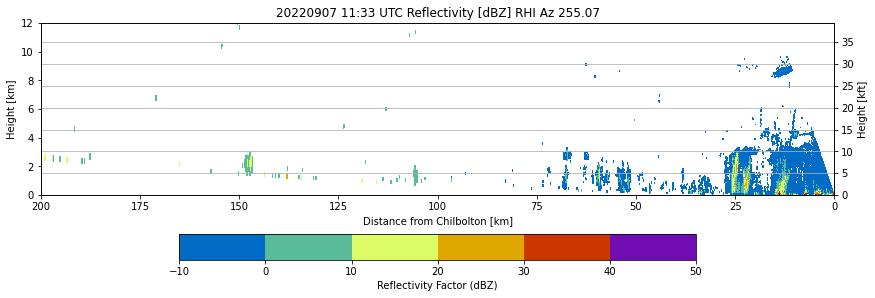

In [39]:
from mpl_axes_aligner import align
km2kft = 1.0/0.3048;

direction,r,x,y,z = scanco(DS);

print(direction)

cmap = plt.cm.get_cmap('pyart_HomeyerRainbow', 6) 
#cmap = plt.cm.get_cmap('pyart_LangRainbow12', 6) 

#cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[-1] = (112/256.,12/256.,179/256., 1.)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)


az = DS['azimuth'][0];

fig, ax = plt.subplots(1,1,figsize=(12,4),constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=2 / 72, h_pad=2 / 72, hspace=0.2,wspace=0.2)

h0=ax.pcolor(r,z,Zh[:-1,:-1],cmap=cmap,vmin=Zscale[0],vmax=Zscale[1])
ax.set_ylim(hscale[0],hscale[1]);
ax.set_xlim(dcscale[0],dcscale[1]);
if direction<0:
    ax.invert_xaxis();
    
ax0 = ax.twinx();
ax0.set_ylim(hscale[0]*km2kft,hscale[1]*km2kft)
ax0.grid(True);

cb0 = plt.colorbar(h0,ax=ax,orientation='horizontal',shrink=0.8);
cb0.ax.set_xlabel("Reflectivity Factor (dBZ)");

ax.set_xlabel('Distance from Chilbolton [km]')
ax.set_ylabel('Height [km]')
ax0.set_ylabel('Height [kft]')
figtitle = '{} Reflectivity [dBZ] RHI Az {:.2f}'.format(title_date,az)
ax.set_title(figtitle)

figname = 'camra_rhi_{}_ZED_H.png'.format(figdate)

plt.savefig(os.path.join(figpath,figname),dpi=150)

In [ ]:
direction,r,x,y,z = scanco(DS);


fig, ax = plt.subplots(1,1,figsize=(12,12),constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=2 / 72, h_pad=2 / 72, hspace=0.2,wspace=0.2)

h0=ax.pcolor(x,y,DS['ZED_H'][:-1,:-1],cmap='pyart_HomeyerRainbow',vmin=Zscale[0],vmax=Zscale[1])
#ax.set_ylim(hscale[0],hscale[1]);
#ax.set_xlim(dcscale[0],dcscale[1]);



el = DS['elevation'][0];


cb0 = plt.colorbar(h0,ax=ax,orientation='horizontal',shrink=0.8);
cb0.ax.set_xlabel("Reflectivity Factor (dBZ)");

ax.set_xlabel('Distance East from Chilbolton [km]')
ax.set_ylabel('Distance North from Chilbolton [km]')
figtitle = '{} Reflectivity [dBZ] PPI El {:.2f}'.format(title_date,el)
ax.set_title(figtitle)
ax.axis('equal')

figname = 'camra_ppi_{}_ZED_H.png'.format(figdate)
figpath = '/home/cw66/public_html/wescon'
plt.savefig(os.path.join(figpath,figname),dpi=75)

In [44]:
print(np.sin(np.mean(DS['azimuth'][:])*np.pi/180))

0.8362861558477593


(59, 2330)
(array([19, 19, 19, ..., 58, 58, 58]), array([2305, 2306, 2307, ..., 2327, 2328, 2329]))
(2, 36892)


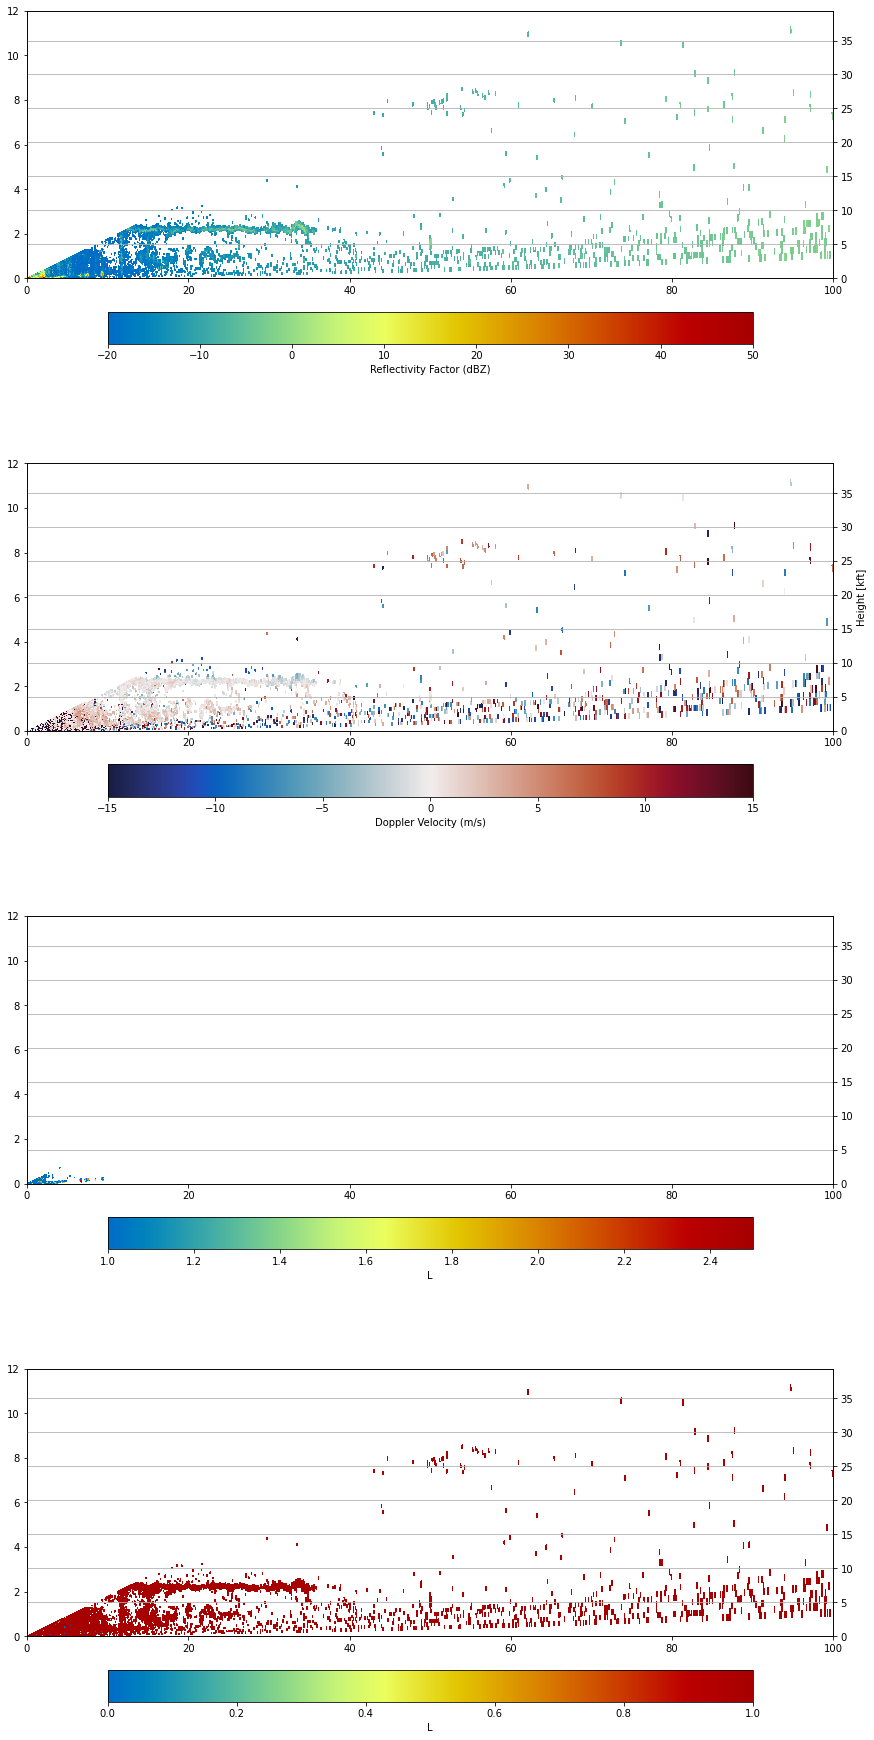

In [19]:
h1=ax[1].pcolor(r,z,V[:-1,:-1],cmap=cmocean.cm.balance,vmin=Vscale[0],vmax=Vscale[1])
ax[1].set_ylim(0,12);
ax[1].set_ylim(hscale[0],hscale[1]);
ax[1].set_xlim(dcscale[0],dcscale[1]);
cb1 = plt.colorbar(h1,ax=ax[1],orientation='horizontal',shrink=0.8);
cb1.ax.set_xlabel("Doppler Velocity (m/s)");
ax1 = ax[1].twinx();
ax1.set_ylim(hscale[0]*km2kft,hscale[1]*km2kft)
ax1.grid(True);
ax1.set_ylabel('Height [kft]')

h2=ax[2].pcolor(r,z,L[:-1,:-1],cmap='pyart_HomeyerRainbow',vmin=Lscale[0],vmax=Lscale[1])
ax[2].set_ylim(0,12);
ax[2].set_ylim(hscale[0],hscale[1]);
ax[2].set_xlim(dcscale[0],dcscale[1]);
cb2 = plt.colorbar(h2,ax=ax[2],orientation='horizontal',shrink=0.8);
cb2.ax.set_xlabel("L");
ax2 = ax[2].twinx();
ax2.set_ylim(hscale[0]*km2kft,hscale[1]*km2kft)
ax2.grid(True);

h3=ax[3].pcolor(r,z,clutter[:-1,:-1],cmap='pyart_HomeyerRainbow',vmin=0,vmax=1)
ax[3].set_ylim(0,12);
ax[3].set_ylim(hscale[0],hscale[1]);
ax[3].set_xlim(dcscale[0],dcscale[1]);
cb3 = plt.colorbar(h3,ax=ax[3],orientation='horizontal',shrink=0.8);
cb3.ax.set_xlabel("L");
ax3 = ax[3].twinx();
ax3.set_ylim(hscale[0]*km2kft,hscale[1]*km2kft)
ax3.grid(True);

In [ ]:
C=clock; theday=C(1)*1e4+C(2)*1e2+C(3)
% to manually set the date you want, uncomment the next line:
% theday=20170112 

% set scales on the plots:
dcscale=[0 200] % horizontal distance from chilbolton
hscale=[0 12]; % height on RHI / MAN plots
Zscale=[-20 30] % reflectivity
ZDRscale=[-1 3] % ZDR
Lscale=[1 2.5] % L
PDPscale=[0 20] % PhiDP
Vscale=[-15 15] % Doppler
SPWscale=[0 2.5] % Spectral width
LDRscale=[-35 -15] % LDR

% add path to ssh functions if not already got this:
addpath /Users/cw66/Documents/MATLAB/ssh2_v2_m1_r6/ssh2_v2_m1_r6
%addpath ('C:\Users\earpac\Documents\MATLAB\program PICASSO\ssh2_v2_m1_r6\ssh2_v2_m1_r6')
addpath ('C:\Users\earpac\Documents\MATLAB\program PICASSO')
% and this is a directory where we can put files (PNG and netCDF)
datadir='C:\Users\earpac\Documents\Data\Reading\radar\PICASSO_data_test\'
cd(datadir)

% check directory listings on Chilbolton server
%camra_raw_dir=['/mnt/focus_radar_data/radar-camra/raw/' num2str(theday) '/']
camra_raw_dir=['/focus/radar-camra/raw/' num2str(theday) '/']
camra_rhi_list = ssh2_simple_command('gate.chobs.rl.ac.uk','cwestbrook','billow',['ls ' camra_raw_dir '*.*c']);
camra_ppi_list = ssh2_simple_command('gate.chobs.rl.ac.uk','cwestbrook','billow',['ls /mnt/focus_radar_data/radar-camra/raw/' num2str(theday) '/*ppi*']);
camra_man_list = ssh2_simple_command('gate.chobs.rl.ac.uk','cwestbrook','billow',['ls /mnt/focus_radar_data/radar-camra/raw/' num2str(theday) '/*man*']);

scantype=choosedialog('What kind of scan? (RHI, PPI, MAN)',{'rhi';'ppi';'man'});

if scantype=='ppi'
    filelist=camra_ppi_list;
elseif scantype=='man'
    filelist=camra_man_list;
else
    filelist=camra_rhi_list;
end

fileoptions=cell(length(filelist),1);
fileoffset=(length(camra_raw_dir)+1);
for jj=1:length(filelist)
    ff=filelist{jj}; gg=ff(fileoffset:end);
    scantime_mins=gg(21:24); scantime_secs=gg(25:26);
    fileoptions{jj}=[scantime_mins ' ' scantime_secs];
end
whichscan=choosedialog('Select a scan time [UTC]',fileoptions);
jj=find(strcmp(fileoptions,whichscan)==1);
disp(['getting file from chilbolton server...' fileoptions{jj} '...(wait for it)...']);
ssh2_conn = scp_simple_get('gate.chobs.rl.ac.uk','cwestbrook','billow',filelist{jj})
ff=filelist{jj}; gg=ff(fileoffset:end);
ls(gg)
d=load_nc_to_struct(gg);

variable_transpose;
camra_calibrate_raw_struct; 

whatnow=choosedialog('What now?',{'create PNGs';'go to matlab prompt'});
if (strcmp(whatnow,'go to matlab prompt')==1)
    return;
end

scantime_mins=gg(21:24); scantime_secs=gg(25:26); az=num2str(round(median(dcal.azimuth),1)); el=num2str(round(median(dcal.elevation),1));
if (strcmp(whatnow,'create PNGs')==1)

if (strcmp(scantype,'rhi')==1)
figure('visible','off'); pcolor(r,z,dcal.ZED_H); caxis(Zscale); title(['Reflectivity [dBZ] ' scantime_mins ' UTC, RHI ' az ' degs']); double_scale_flight; figure_template_flight(['camra_rhi_' scantime_mins '_' scantime_secs '_ZED_H']); 
clf; pcolor(r,z,dcal.ZDR); caxis(ZDRscale); title(['Z_{DR} [dB] ' scantime_mins ' UTC, RHI ' az ' degs']); double_scale_flight; figure_template_flight(['camra_rhi_' scantime_mins '_' scantime_secs '_ZDR']); 
clf; pcolor(r,z,dcal.LDR); caxis(LDRscale); title(['LDR [dB] (strong echoes only) ' scantime_mins ' UTC, RHI ' az ' degs']); double_scale_flight; figure_template_flight(['camra_rhi_' scantime_mins '_' scantime_secs '_LDR']); 
clf; pcolor(r,z,dcal.PDP); caxis(PDPscale); title(['\Phi_{DP} [degs] ' scantime_mins ' UTC, RHI ' az ' degs']); double_scale_flight; figure_template_flight(['camra_rhi_' scantime_mins '_' scantime_secs '_PDP']); 
clf; pcolor(r,z,dcal.VEL_HV); caxis(Vscale); title(['Doppler Velocity [m/s] ' scantime_mins ' UTC, RHI ' az ' degs']); double_scale_flight; figure_template_flight(['camra_rhi_' scantime_mins '_' scantime_secs '_VEL_HV']); 
clf; pcolor(r,z,dcal.SPW_HV); caxis(SPWscale); title(['Spectral Width [m/s] (strong echoes only) ' scantime_mins ' UTC, RHI ' az ' degs']); double_scale_flight; figure_template_flight(['camra_rhi_' scantime_mins '_' scantime_secs '_SPW_HV']); 
clf; pcolor(r,z,dcal.L); caxis(Lscale); title(['L=-(1-\rho_{hv}) (strong echoes only) ' scantime_mins ' UTC, RHI ' az ' degs']); double_scale_flight; figure_template_flight(['camra_rhi_' scantime_mins '_' scantime_secs '_L']); 
clf; pcolor(r,z,dcal.clutter); caxis([-1 1]); title(['''likely-clutter'' flag ' scantime_mins ' UTC, RHI ' az ' degs']); double_scale_flight; figure_template_flight(['camra_rhi_' scantime_mins '_' scantime_secs '_clutter']); 
clf;

htmlfile=['camra_rhi_' scantime_mins '_' scantime_secs '.html']
fileID = fopen(htmlfile,'w');
fprintf(fileID,'%s\n','<HTML>');
fprintf(fileID,'%s\n',['<IMG SRC=plots/' 'camra_rhi_' scantime_mins '_' scantime_secs '_ZED_H' '.png' '><BR>']);
fprintf(fileID,'%s\n',['<IMG SRC=plots/' 'camra_rhi_' scantime_mins '_' scantime_secs '_ZDR' '.png' '><BR>']);
fprintf(fileID,'%s\n',['<IMG SRC=plots/' 'camra_rhi_' scantime_mins '_' scantime_secs '_LDR' '.png' '><BR>']);
fprintf(fileID,'%s\n',['<IMG SRC=plots/' 'camra_rhi_' scantime_mins '_' scantime_secs '_PDP' '.png' '><BR>']);
fprintf(fileID,'%s\n',['<IMG SRC=plots/' 'camra_rhi_' scantime_mins '_' scantime_secs '_VEL_HV' '.png' '><BR>']);
fprintf(fileID,'%s\n',['<IMG SRC=plots/' 'camra_rhi_' scantime_mins '_' scantime_secs '_SPW_HV' '.png' '><BR>']);
fprintf(fileID,'%s\n',['<IMG SRC=plots/' 'camra_rhi_' scantime_mins '_' scantime_secs '_L' '.png' '><BR>']);
fprintf(fileID,'%s\n',['<IMG SRC=plots/' 'camra_rhi_' scantime_mins '_' scantime_secs '_clutter' '.png' '><BR>']);
fprintf(fileID,'%s\n','</HTML>');
fclose(fileID);

plotlocation=['/home/cwestbrook/public_html/picasso/' num2str(theday)]
ssh2_conn = ssh2_config('gate.chobs.rl.ac.uk','cwestbrook','billow');
ssh2_conn.remote_file_mode = 0644; % makes sure the files are readable by all (permissions)
ssh2_conn = ssh2_command(ssh2_conn, ['mkdir ' plotlocation]);
ssh2_conn = ssh2_command(ssh2_conn, ['mkdir ' plotlocation '/plots']);
ssh2_conn = scp_put(ssh2_conn, ['camra_rhi_' scantime_mins '_' scantime_secs '_ZED_H' '.png'],[plotlocation '/plots/']);
ssh2_conn = scp_put(ssh2_conn, ['camra_rhi_' scantime_mins '_' scantime_secs '_ZDR' '.png'],[plotlocation '/plots/']);
ssh2_conn = scp_put(ssh2_conn, ['camra_rhi_' scantime_mins '_' scantime_secs '_LDR' '.png'],[plotlocation '/plots/']);
ssh2_conn = scp_put(ssh2_conn, ['camra_rhi_' scantime_mins '_' scantime_secs '_PDP' '.png'],[plotlocation '/plots/']);
ssh2_conn = scp_put(ssh2_conn, ['camra_rhi_' scantime_mins '_' scantime_secs '_VEL_HV' '.png'],[plotlocation '/plots/']);
ssh2_conn = scp_put(ssh2_conn, ['camra_rhi_' scantime_mins '_' scantime_secs '_SPW_HV' '.png'],[plotlocation '/plots/']);
ssh2_conn = scp_put(ssh2_conn, ['camra_rhi_' scantime_mins '_' scantime_secs '_L' '.png'],[plotlocation '/plots/']);
ssh2_conn = scp_put(ssh2_conn, ['camra_rhi_' scantime_mins '_' scantime_secs '_clutter' '.png'],[plotlocation '/plots/']);
ssh2_conn = scp_put(ssh2_conn, htmlfile,plotlocation);
ssh2_conn = ssh2_close(ssh2_conn); %will call ssh2.m and run command and then close connection

end % rhi

if (strcmp(scantype,'ppi')==1)
    figure('visible','off'); pcolor(x,y,dcal.ZED_H); caxis(Zscale); title(['Reflectivity [dBZ] ' scantime_mins ' UTC, PPI ' el ' degs']); colorbar; chiljet; shading flat; ylim([-dcscale(2) dcscale(2)]); xlim([-dcscale(2) dcscale(2)]); figure_template_flight_ppi(['camra_ppi_' scantime_mins '_' scantime_secs '_ZED_H']); 
clf; pcolor(x,y,dcal.ZDR); caxis(ZDRscale); title(['Z_{DR} [dB] ' scantime_mins ' UTC, PPI ' el ' degs']); colorbar; chiljet; shading flat; ylim([-dcscale(2) dcscale(2)]); xlim([-dcscale(2) dcscale(2)]); figure_template_flight_ppi(['camra_ppi_' scantime_mins '_' scantime_secs '_ZDR']); 
clf; pcolor(x,y,dcal.LDR); caxis(LDRscale); title(['LDR [dB] (strong echoes only) ' scantime_mins ' UTC, PPI ' el ' degs']);  colorbar; chiljet; shading flat; ylim([-dcscale(2) dcscale(2)]); xlim([-dcscale(2) dcscale(2)]); figure_template_flight_ppi(['camra_ppi_' scantime_mins '_' scantime_secs '_LDR']); 
clf; pcolor(x,y,dcal.PDP); caxis(PDPscale); title(['\Phi_{DP} [degs] ' scantime_mins ' UTC, PPI ' el ' degs']);  colorbar; chiljet; shading flat; ylim([-dcscale(2) dcscale(2)]); xlim([-dcscale(2) dcscale(2)]); figure_template_flight_ppi(['camra_ppi_' scantime_mins '_' scantime_secs '_PDP']); 
clf; pcolor(x,y,dcal.VEL_HV); caxis(Vscale); title(['Doppler Velocity [m/s] ' scantime_mins ' UTC, PPI ' el ' degs']);  colorbar; chiljet; shading flat; ylim([-dcscale(2) dcscale(2)]); xlim([-dcscale(2) dcscale(2)]); figure_template_flight_ppi(['camra_ppi_' scantime_mins '_' scantime_secs '_VEL_HV']); 
clf; pcolor(x,y,dcal.SPW_HV); caxis(SPWscale); title(['Spectral Width [m/s] (strong echoes only) ' scantime_mins ' UTC, PPI ' el ' degs']);  colorbar; chiljet; shading flat; ylim([-dcscale(2) dcscale(2)]); xlim([-dcscale(2) dcscale(2)]); figure_template_flight_ppi(['camra_ppi_' scantime_mins '_' scantime_secs '_SPW_HV']); 
clf; pcolor(x,y,dcal.L); caxis(Lscale); title(['L=-(1-\rho_{hv}) (strong echoes only) ' scantime_mins ' UTC, PPI ' el ' degs']);  colorbar; chiljet; shading flat; ylim([-dcscale(2) dcscale(2)]); xlim([-dcscale(2) dcscale(2)]); figure_template_flight_ppi(['camra_ppi_' scantime_mins '_' scantime_secs '_L']); 
clf; pcolor(x,y,dcal.clutter); caxis([-1 1]); title(['''likely-clutter'' flag ' scantime_mins ' UTC, PPI ' el ' degs']); colorbar; chiljet; shading flat; ylim([-dcscale(2) dcscale(2)]); xlim([-dcscale(2) dcscale(2)]); figure_template_flight_ppi(['camra_ppi_' scantime_mins '_' scantime_secs '_clutter']); 
clf;

htmlfile=['camra_ppi_' scantime_mins '_' scantime_secs '.html']
fileID = fopen(htmlfile,'w');
fprintf(fileID,'%s\n','<HTML>');
fprintf(fileID,'%s\n',['<IMG SRC=plots/' 'camra_ppi_' scantime_mins '_' scantime_secs '_ZED_H' '.png' '><BR>']);
fprintf(fileID,'%s\n',['<IMG SRC=plots/' 'camra_ppi_' scantime_mins '_' scantime_secs '_ZDR' '.png' '><BR>']);
fprintf(fileID,'%s\n',['<IMG SRC=plots/' 'camra_ppi_' scantime_mins '_' scantime_secs '_LDR' '.png' '><BR>']);
fprintf(fileID,'%s\n',['<IMG SRC=plots/' 'camra_ppi_' scantime_mins '_' scantime_secs '_PDP' '.png' '><BR>']);
fprintf(fileID,'%s\n',['<IMG SRC=plots/' 'camra_ppi_' scantime_mins '_' scantime_secs '_VEL_HV' '.png' '><BR>']);
fprintf(fileID,'%s\n',['<IMG SRC=plots/' 'camra_ppi_' scantime_mins '_' scantime_secs '_SPW_HV' '.png' '><BR>']);
fprintf(fileID,'%s\n',['<IMG SRC=plots/' 'camra_ppi_' scantime_mins '_' scantime_secs '_L' '.png' '><BR>']);
fprintf(fileID,'%s\n',['<IMG SRC=plots/' 'camra_ppi_' scantime_mins '_' scantime_secs '_clutter' '.png' '><BR>']);
fprintf(fileID,'%s\n','</HTML>');
fclose(fileID);

plotlocation=['/home/cwestbrook/public_html/picasso/' num2str(theday)]
ssh2_conn = ssh2_config('gate.chobs.rl.ac.uk','cwestbrook','billow');
ssh2_conn.remote_file_mode = 0644; % makes sure the files are readable by all (permissions)
ssh2_conn = ssh2_command(ssh2_conn, ['mkdir ' plotlocation]);
ssh2_conn = ssh2_command(ssh2_conn, ['mkdir ' plotlocation '/plots']);
ssh2_conn = scp_put(ssh2_conn, ['camra_ppi_' scantime_mins '_' scantime_secs '_ZED_H' '.png'],[plotlocation '/plots/']);
ssh2_conn = scp_put(ssh2_conn, ['camra_ppi_' scantime_mins '_' scantime_secs '_ZDR' '.png'],[plotlocation '/plots/']);
ssh2_conn = scp_put(ssh2_conn, ['camra_ppi_' scantime_mins '_' scantime_secs '_LDR' '.png'],[plotlocation '/plots/']);
ssh2_conn = scp_put(ssh2_conn, ['camra_ppi_' scantime_mins '_' scantime_secs '_PDP' '.png'],[plotlocation '/plots/']);
ssh2_conn = scp_put(ssh2_conn, ['camra_ppi_' scantime_mins '_' scantime_secs '_VEL_HV' '.png'],[plotlocation '/plots/']);
ssh2_conn = scp_put(ssh2_conn, ['camra_ppi_' scantime_mins '_' scantime_secs '_SPW_HV' '.png'],[plotlocation '/plots/']);
ssh2_conn = scp_put(ssh2_conn, ['camra_ppi_' scantime_mins '_' scantime_secs '_L' '.png'],[plotlocation '/plots/']);
ssh2_conn = scp_put(ssh2_conn, ['camra_ppi_' scantime_mins '_' scantime_secs '_clutter' '.png'],[plotlocation '/plots/']);
ssh2_conn = scp_put(ssh2_conn, htmlfile,plotlocation);
ssh2_conn = ssh2_close(ssh2_conn); %will call ssh2.m and run command and then close connection

end % ppi

if (strcmp(scantype,'man')==1)
    timeUTC=dcal.time/3600;
    figure; subplot(2,1,1); plot(timeUTC,dcal.elevation); grid on; ylabel('Elevation [degs]'); xlabel('Time [UTC]'); ylim([0 90])
    subplot(2,1,2); plot(timeUTC,dcal.azimuth); grid on; ylabel('Azimuth [degs]'); xlabel('Time [UTC]')
   
    updown=choosedialog('Up or Down part of scan?',{'Up';'Down'});
if (strcmp(updown,'Up')==1)
    iguessstart=1; index=find(dcal.elevation==90); if (length(index)>=1) iguessmiddle=index(1); else iguessmiddle=length(timeUTC); end
    guessstart=num2str(timeUTC(iguessstart));  guessmiddle=num2str(timeUTC(iguessmiddle)); 

    prompt = {'Start Time:','Stop Time:'};
    dlg_title = 'Select segment to plot';
    num_lines = 1;
    defaultans = {guessstart,guessmiddle};
    answer = inputdlg(prompt,dlg_title,num_lines,defaultans);
end % up
if (strcmp(updown,'Down')==1)
    iguessend=length(timeUTC); index=find(dcal.elevation==90); if (length(index)>=1) iguessmiddle=index(1); else iguessmiddle=1; end 
    guessend=num2str(timeUTC(iguessend));  guessmiddle=num2str(timeUTC(iguessmiddle)); 

    prompt = {'Start Time:','Stop Time:'};
    dlg_title = 'Select segment to plot';
    num_lines = 1;
    defaultans = {guessmiddle,guessend};
    answer = inputdlg(prompt,dlg_title,num_lines,defaultans);
end % down

    starttime=str2num(answer{1})
    stoptime=str2num(answer{2})
    index=find(timeUTC>=starttime & timeUTC<=stoptime);

    r=r(index,:);
    z=z(index,:);
    dcal.ZED_H=dcal.ZED_H(index,:);
    dcal.ZDR=dcal.ZDR(index,:);          
    dcal.VEL_HV=dcal.VEL_HV(index,:);
    dcal.SPW_HV=dcal.SPW_HV(index,:);
    dcal.LDR=dcal.LDR(index,:);          
    dcal.L=dcal.L(index,:);          
    dcal.PDP=dcal.PDP(index,:);          
    dcal.clutter=dcal.clutter(index,:);          

    figure('visible','off'); pcolor(r,z,dcal.ZED_H); caxis(Zscale); title(['Reflectivity [dBZ] ' scantime_mins ' UTC, MAN ' updown]); double_scale_flight; figure_template_flight(['camra_man_' updown scantime_mins '_' scantime_secs '_ZED_H']); 
    clf; pcolor(r,z,dcal.ZDR); caxis(ZDRscale); title(['Z_{DR} [dB] ' scantime_mins ' UTC, MAN ' updown]); double_scale_flight; figure_template_flight(['camra_man_' updown scantime_mins '_' scantime_secs '_ZDR']); 
clf; pcolor(r,z,dcal.VEL_HV); caxis(Vscale); title(['Doppler Velocity [m/s] ' scantime_mins ' UTC, MAN ' updown]); double_scale_flight; figure_template_flight(['camra_man_' updown scantime_mins '_' scantime_secs '_VEL_HV']); 
clf; pcolor(r,z,dcal.SPW_HV); caxis(SPWscale); title(['Spectral Width [m/s] (strong echoes only) ' scantime_mins ' UTC, MAN ' updown]); double_scale_flight; figure_template_flight(['camra_man_' updown scantime_mins '_' scantime_secs '_SPW_HV']); 
clf; pcolor(r,z,dcal.LDR); caxis(LDRscale); title(['LDR [dB] (strong echoes only) ' scantime_mins ' UTC, MAN ' updown]); double_scale_flight; figure_template_flight(['camra_man_' updown scantime_mins '_' scantime_secs '_LDR']); 
clf; pcolor(r,z,dcal.L); caxis(Lscale); title(['L=-log(1-\rho{hv}) (strong echoes only) ' scantime_mins ' UTC, MAN ' updown]); double_scale_flight; figure_template_flight(['camra_man_' updown scantime_mins '_' scantime_secs '_L']); 
clf; pcolor(r,z,dcal.PDP); caxis(PDPscale); title(['\Phi_{dp} [degs] ' scantime_mins ' UTC, MAN ' updown]); double_scale_flight; figure_template_flight(['camra_man_' updown scantime_mins '_' scantime_secs '_PDP']); 
clf; pcolor(r,z,dcal.clutter); caxis([-1 1]); title(['''likely-clutter'' flag ' scantime_mins ' UTC, MAN ' updown]); double_scale_flight; figure_template_flight(['camra_man_' updown scantime_mins '_' scantime_secs '_clutter']); 
clf;

htmlfile=['camra_man_' updown scantime_mins '_' scantime_secs '.html']
fileID = fopen(htmlfile,'w');
fprintf(fileID,'%s\n','<HTML>');
fprintf(fileID,'%s\n',['<IMG SRC=plots/' 'camra_man_' updown scantime_mins '_' scantime_secs '_ZED_H' '.png' '><BR>']);
fprintf(fileID,'%s\n',['<IMG SRC=plots/' 'camra_man_' updown scantime_mins '_' scantime_secs '_ZDR' '.png' '><BR>']);
fprintf(fileID,'%s\n',['<IMG SRC=plots/' 'camra_man_' updown scantime_mins '_' scantime_secs '_VEL_HV' '.png' '><BR>']);
fprintf(fileID,'%s\n',['<IMG SRC=plots/' 'camra_man_' updown scantime_mins '_' scantime_secs '_SPW_HV' '.png' '><BR>']);
fprintf(fileID,'%s\n',['<IMG SRC=plots/' 'camra_man_' updown scantime_mins '_' scantime_secs '_LDR' '.png' '><BR>']);
fprintf(fileID,'%s\n',['<IMG SRC=plots/' 'camra_man_' updown scantime_mins '_' scantime_secs 'L' '.png' '><BR>']);
fprintf(fileID,'%s\n',['<IMG SRC=plots/' 'camra_man_' updown scantime_mins '_' scantime_secs '_PDP' '.png' '><BR>']);
fprintf(fileID,'%s\n',['<IMG SRC=plots/' 'camra_man_' updown scantime_mins '_' scantime_secs '_clutter' '.png' '><BR>']);
fprintf(fileID,'%s\n','</HTML>');
fclose(fileID);

plotlocation=['/home/cwestbrook/public_html/picasso/' num2str(theday)]
ssh2_conn = ssh2_config('gate.chobs.rl.ac.uk','cwestbrook','billow');
ssh2_conn.remote_file_mode = 0644; % makes sure the files are readable by all (permissions)
ssh2_conn = ssh2_command(ssh2_conn, ['mkdir ' plotlocation]);
ssh2_conn = ssh2_command(ssh2_conn, ['mkdir ' plotlocation '/plots']);
ssh2_conn = scp_put(ssh2_conn, ['camra_man_' updown scantime_mins '_' scantime_secs '_ZED_H' '.png'],[plotlocation '/plots/']);
ssh2_conn = scp_put(ssh2_conn, ['camra_man_' updown scantime_mins '_' scantime_secs '_ZDR' '.png'],[plotlocation '/plots/']);
ssh2_conn = scp_put(ssh2_conn, ['camra_man_' updown scantime_mins '_' scantime_secs '_VEL_HV' '.png'],[plotlocation '/plots/']);
ssh2_conn = scp_put(ssh2_conn, ['camra_man_' updown scantime_mins '_' scantime_secs '_SPW_HV' '.png'],[plotlocation '/plots/']);
ssh2_conn = scp_put(ssh2_conn, ['camra_man_' updown scantime_mins '_' scantime_secs '_LDR' '.png'],[plotlocation '/plots/']);
ssh2_conn = scp_put(ssh2_conn, ['camra_man_' updown scantime_mins '_' scantime_secs '_L' '.png'],[plotlocation '/plots/']);
ssh2_conn = scp_put(ssh2_conn, ['camra_man_' updown scantime_mins '_' scantime_secs '_PDP' '.png'],[plotlocation '/plots/']);
ssh2_conn = scp_put(ssh2_conn, ['camra_man_' updown scantime_mins '_' scantime_secs '_clutter' '.png'],[plotlocation '/plots/']);

ssh2_conn = scp_put(ssh2_conn, htmlfile,plotlocation);
ssh2_conn = ssh2_close(ssh2_conn); %will call ssh2.m and run command and then close connection

end % man


end % plot to PNGs

deletedata=choosedialog('Delete local copy of netcdf data file?',{'Yes';'No'});
if (strcmp(deletedata,'Yes')==1)
    delete(gg)
end

web(['https://gate.chobs.rl.ac.uk/~cwestbrook/picasso/' num2str(theday) '/' htmlfile])
disp('Done. Plots should be at https://gate.chobs.rl.ac.uk/~cwestbrook/picasso/')
disp('If want to do some custom plots, calibrated data is in dcal structure; co-ordinate arrays are r,z,x,y')
disp('can use figure_template_flight(filename-without-png-extension) to produce well formatted plots')
disp('type cross_section to plot out vertical or horizontal cross sections from RHI scans')


In [ ]:


thetimeis=(d.time(1)/3600);
hrs=floor(thetimeis);
mins=floor((thetimeis-hrs)*60);
if mins<10
timestring=[num2str(hrs) '0' num2str(mins)];
elseif mins<1
timestring=[num2str(hrs) '00'];
else
timestring=[num2str(hrs) num2str(mins)];
end
secsstring=num2str(floor((thetimeis-(hrs+mins/60))*3600));



% identify likely clutter:
clutter=Zh;
index=find(isnan(Zh)==0); clutter(index)=0; % start with all datapoints =0 
index=find(ZDR<-3); clutter(index)=1; % anything with large negative ZDR
index=find(LDR>-10); clutter(index)=1; % anything with very high LDR
index=find(CXC<0.5); clutter(index)=1; % anything with really small rho_hv
index=find(PDP<-30); clutter(index)=1; % anything with large negative PDP
index=find(abs(V)<0.15 & clutter==0); clutter(index)=0.5; % anything not already flagged but with V very close to 0

dcal=d;
dcal.ZED_H=Zh; dcal.ZDR=ZDR; dcal.VEL_HV=V; dcal.PDP=PDP; dcal.LDR=LDR; dcal.L=L; dcal.SPW_HV=SPW_HV; dcal.clutter=clutter; 
%clear Zh Zv Zx ZDR V PDP LDR SPW_HV L linZ linZv linZx signalpower signalpowerv signalpowerx 

%end %% catch for empty files length(linZ)>0